## Libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import pickle

from sklearn.linear_model import LogisticRegression 

import matplotlib.pyplot as plt
import matplotlib.axes as axs
import seaborn as sns
sns.set()

from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

## Data Preparation

In [2]:
df_purchase = pd.read_csv('Data\Raw_Data\purchase data.csv')

scaler = pickle.load(open('Data/Pickle_Saves/scaler.pickle', 'rb'))

pca = pickle.load(open('Data/Pickle_Saves/pca.pickle', 'rb'))

kmeans_pca = pickle.load(open('Data/Pickle_Saves/kmeans_pca.pickle', 'rb'))

In [3]:
df_purchase.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,...,0,0,0,0,0,47,1,110866,1,0
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,...,0,0,0,0,0,47,1,110866,1,0
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,...,0,0,0,0,0,47,1,110866,1,0
3,200000001,16,0,0,0,0,0,1.52,1.89,1.98,...,0,0,0,0,0,47,1,110866,1,0
4,200000001,18,0,0,0,0,0,1.52,1.89,1.99,...,0,0,0,0,0,47,1,110866,1,0


> We have purchase data of 5 brands of chocolate bars and customer purchase data for 500 different customers for various days. Dataset also includes data about whether there was a promotion for each of the brands on particular day.

In [4]:
# Pickle load check

kmeans_pca.n_clusters

4

In [5]:
# Standardization

features = df_purchase[['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']]
df_purchase_segm_std = scaler.transform(features)

# Applying PCA

df_purchase_segm_pca = pca.transform(df_purchase_segm_std)

# Segmenting data

purchase_segm_kmeans_pca = kmeans_pca.predict(df_purchase_segm_pca)

# Copy of the data frame to add segment labels

df_purchase_predictors = df_purchase.copy()
df_purchase_predictors['Segment'] = purchase_segm_kmeans_pca
segment_dummies = pd.get_dummies(purchase_segm_kmeans_pca, prefix = 'Segment', prefix_sep = '_')
df_purchase_predictors = pd.concat([df_purchase_predictors, segment_dummies], axis = 1)

## Purchase Probability Model

In [6]:
# Creating copy for purchase probabilty

df_pa = df_purchase_predictors

df_pa.columns

Index(['ID', 'Day', 'Incidence', 'Brand', 'Quantity', 'Last_Inc_Brand',
       'Last_Inc_Quantity', 'Price_1', 'Price_2', 'Price_3', 'Price_4',
       'Price_5', 'Promotion_1', 'Promotion_2', 'Promotion_3', 'Promotion_4',
       'Promotion_5', 'Sex', 'Marital status', 'Age', 'Education', 'Income',
       'Occupation', 'Settlement size', 'Segment', 'Segment_0', 'Segment_1',
       'Segment_2', 'Segment_3'],
      dtype='object')

In [7]:
# Dependant variable Y is Incidence, as we want to predict the purchase probability for our customers

Y = df_pa['Incidence']

Y.unique()

array([0, 1], dtype=int64)

In [8]:
# We will model the purchase probability based on selling price of chocolate as a benchmark model. 
# Here we will consider the mean of the 5 brands

price_cols = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']

X = pd.DataFrame()
X['Mean_Price'] = df_pa.loc[:,price_cols].mean(axis = 1) 

In [9]:
# Model Fitting

model_purchase = LogisticRegression(solver = 'sag')
model_purchase.fit(X, Y)

LogisticRegression(solver='sag')

In [10]:
# The coefficients for price. It is negative, signaling that with an increase in price, the purchase probability decreases.

model_purchase.coef_

array([[-2.34754205]])

## Price Elasticity of Purchase Probability

In [11]:
# Here we see the prices for the 5 different brands, which is an important factor in determining purchase probability. 

df_pa[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000000,58693.000000,58693.000000,58693.000000,58693.000000
mean,1.392074,1.780999,2.006789,2.159945,2.654798
std,0.091139,0.170868,0.046867,0.089825,0.098272
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.580000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.170000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


> We create the price range for which we'll examine the purchase probability. We choose a price range between 0.5 and 3.5, which covers the actual observed price range, which is from 1.1 (min of price_1) to 2.8 (max of price_5).

In [12]:
price_range = np.arange(0.5, 3.5, 0.01)
price_range

array([0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 ,
       0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71,
       0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82,
       0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93,
       0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  , 1.01, 1.02, 1.03, 1.04,
       1.05, 1.06, 1.07, 1.08, 1.09, 1.1 , 1.11, 1.12, 1.13, 1.14, 1.15,
       1.16, 1.17, 1.18, 1.19, 1.2 , 1.21, 1.22, 1.23, 1.24, 1.25, 1.26,
       1.27, 1.28, 1.29, 1.3 , 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37,
       1.38, 1.39, 1.4 , 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48,
       1.49, 1.5 , 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59,
       1.6 , 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1.7 ,
       1.71, 1.72, 1.73, 1.74, 1.75, 1.76, 1.77, 1.78, 1.79, 1.8 , 1.81,
       1.82, 1.83, 1.84, 1.85, 1.86, 1.87, 1.88, 1.89, 1.9 , 1.91, 1.92,
       1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.

In [13]:
df_price_range = pd.DataFrame(price_range)

In [14]:
# We predict the purchase probability for our newly defined price range using the model we fit on original dataset.

Y_pr = model_purchase.predict_proba(df_price_range)

# We will take the values in column 2 which shows probability for purchase (incidence = 1)

purchase_pr = Y_pr[:][:, 1]

# Price elasticity for own brand is defined as follows: 

pe = model_purchase.coef_[:, 0] * price_range * (1 - purchase_pr)

In [15]:
pe[:5]

array([-0.09636296, -0.10042908, -0.1046221 , -0.10894517, -0.11340149])

In [16]:
# Create price elasticities master data frame which will contain all the elasticities we calculate further.

df_price_elasticities = pd.DataFrame(price_range)

In [17]:
df_price_elasticities = df_price_elasticities.rename(columns = {0: "Price_Point"})
df_price_elasticities['PE'] = pe
df_price_elasticities

,Price_Point,PE
0,0.50,-0.096363
1,0.51,-0.100429
2,0.52,-0.104622
3,0.53,-0.108945
4,0.54,-0.113401
...,...,...
295,3.45,-8.011004
296,3.46,-8.036251
297,3.47,-8.061463
298,3.48,-8.086642


In [18]:
df_price_elasticities.loc[df_price_elasticities.PE <= -1].head(1)

,Price_Point,PE
75,1.25,-1.004142


Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

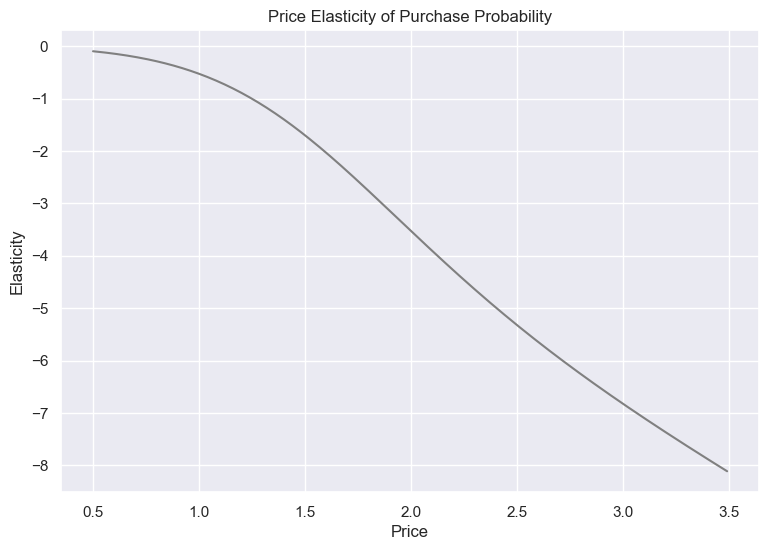

In [19]:
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

> We observe that the price elasticities are all negative meaning increasing our price decreases the probabitlity that the customer buys the product. Furthermore we can spot where the customer becomes inelastic (point where PE > 1 for 1% price increase), which in our case is at price 1.24$

## Purchase Probability by Segments

In [20]:
model_incidence_segment_coef = {}

def Segmented_Purchase_Proba(segment_val):
    
    global model_incidence_segment_coef, df_pa, df_price_range, price_range
    
    seg_val_text = str(segment_val)
    
    df_pa_segment = df_pa[df_pa['Segment'] == segment_val]
    
    # Again we want to predict the purchase probability, so our Y variable is the incidence column.
    Y = df_pa_segment['Incidence']
    
    # We calculate the average price for purchases in the segments. Our dependant variable contains the mean price of the brands.
    X = pd.DataFrame()
    X['Mean_Price'] = df_pa_segment.loc[:, price_cols].mean(axis = 1)
    
    # Fit logistic regression model
    model_incidence_segment = LogisticRegression(solver = 'sag')
    model_incidence_segment.fit(X, Y)
    
    model_incidence_segment_coef['Segment ' + seg_val_text] = round(model_incidence_segment.coef_[0,0],3)
    
    # Calculate Price Elasticity of the career-focused segment.
    Y_segment = model_incidence_segment.predict_proba(df_price_range)
    purchase_pr_segment = Y_segment[:][:, 1]
    pe_segment = model_incidence_segment.coef_[:, 0] * price_range * (1 - purchase_pr_segment)
    
    return pe_segment

In [21]:
for seg in sorted(df_pa['Segment'].unique()):
    
    df_price_elasticities['PE_Segment_' + str(seg)] = Segmented_Purchase_Proba(seg)
    
print('Model Coefficients for each segment: ', model_incidence_segment_coef, end = '\n\n')

df_price_elasticities

Model Coefficients for each segment:  {'Segment 0': -1.508, 'Segment 1': -1.712, 'Segment 2': -3.64, 'Segment 3': -1.246}



,Price_Point,PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3
0,0.50,-0.096363,-0.211189,-0.119112,-0.030946,-0.168026
1,0.51,-0.100429,-0.217759,-0.123295,-0.032714,-0.172951
2,0.52,-0.104622,-0.224437,-0.127572,-0.034570,-0.177946
3,0.53,-0.108945,-0.231224,-0.131943,-0.036516,-0.183012
4,0.54,-0.113401,-0.238120,-0.136411,-0.038557,-0.188149
...,...,...,...,...,...,...
295,3.45,-8.011004,-5.051420,-5.679792,-12.542863,-4.022612
296,3.46,-8.036251,-5.068275,-5.699946,-12.579782,-4.037481
297,3.47,-8.061463,-5.085112,-5.720064,-12.616684,-4.052333
298,3.48,-8.086642,-5.101930,-5.740144,-12.653571,-4.067170


Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

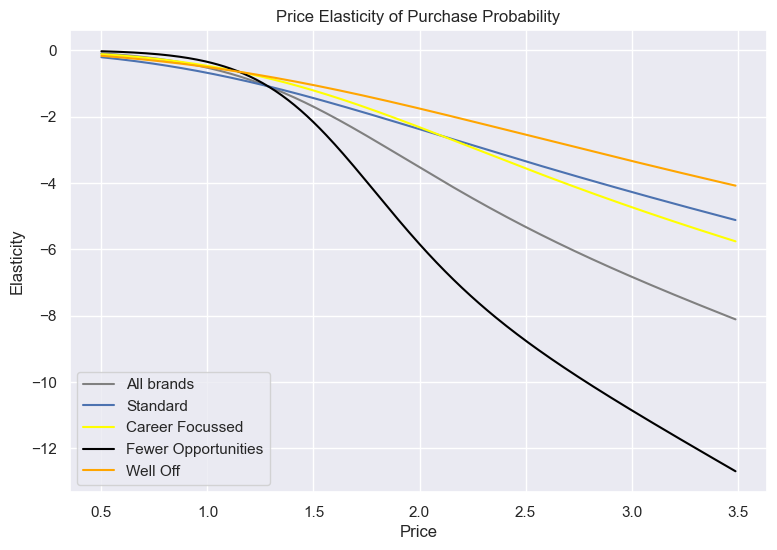

In [22]:
# We display all elasticities of purchase probability on the same plot. 

plt.figure(figsize = (9, 6))
plt.plot(price_range, df_price_elasticities.PE, color = 'grey')
plt.plot(price_range, df_price_elasticities.PE_Segment_0, color = 'b')
plt.plot(price_range, df_price_elasticities.PE_Segment_1, color = 'yellow')
plt.plot(price_range, df_price_elasticities.PE_Segment_2, color = 'black')
plt.plot(price_range, df_price_elasticities.PE_Segment_3, color = 'orange')
plt.legend(['All brands','Standard','Career Focussed','Fewer Opportunities','Well Off'])
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

* We observe that the Career-focused segment are the least elastic when compared to the rest. They are more likely to still purchase when prices increase more than other segments.


* The price elasticities for the Standard segment seem to differ across price range. This may be due to the fact that the standard segment is least homogenous, which we discovered during our descriptive analysis. It may be that the customers in this segment have different shopping habits, which is why their customers start with being more elastic than average but then shift to being more inelastic than the average customer.


* We see that FO segement is inelastic for a sligthly higher price increment than others. But once they become elastic, their elasticity falls rapidly compared to the others. One reason might be that the price increase could be more than they could afford and hence they aren't comfortable with higher than avg price hikes.

## Purchase Probability with Promotion Feature

### Data Preparation

In [23]:
Y = df_pa['Incidence']

X = pd.DataFrame()
X['Mean_Price'] = df_pa.loc[:, price_cols].mean(axis = 1)

In [24]:
# Now, we will add another independant variable to our model, Promotion feature, 
# to see how elasticity varies with both Avg. Price and Promotion

promo_cols = ['Promotion_1' ,'Promotion_2' ,'Promotion_3' ,'Promotion_4' ,'Promotion_5' ]

X['Mean_Promotion'] = df_pa.loc[:, promo_cols].mean(axis = 1)

X

,Mean_Price,Mean_Promotion
0,2.044,0.2
1,2.028,0.0
2,2.028,0.0
3,2.028,0.0
4,2.030,0.0
...,...,...
58688,2.060,0.2
58689,2.060,0.0
58690,2.086,0.0
58691,2.092,0.0


## Model Estimation

In [25]:
model_incidence_promotion = LogisticRegression(solver = 'sag')
model_incidence_promotion.fit(X.iloc[:,:2], Y)
model_incidence_promotion.coef_

array([[-1.49398673,  0.56176367]])

> The coefficient for promotion is positive. Therefore, there is a positive relationship between promotion and purchase probability.

## Price Elasticity with Promotion

In [26]:
def Promo_Price_Elasticity(promo_val):
    
    global price_range, model_incidence_promotion
    
    # We create a data frame on which our model will predict. We need to include A price and promotion feature.
    # First, we'll include the price range as the price feature. Next, we'll include the promotion feature.
    df_price_elasticity_promotion = pd.DataFrame(price_range)
    df_price_elasticity_promotion = df_price_elasticity_promotion.rename(columns = {0: "Price_Range"})

    # We'll calculate price elasticities of purchase probability when we assume there is and 
    # isn't a promotion across all price points.
    df_price_elasticity_promotion['Promotion'] = promo_val
    
    # Purchase Probability based on Promotion 
    promo_prob = model_incidence_promotion.predict_proba(df_price_elasticity_promotion)[:, 1]
    price_elasticity_promo = (model_incidence_promotion.coef_[:, 0] * price_range) * (1 - promo_prob)
    
    return price_elasticity_promo

In [27]:
for promo in [0,1]:
    
    df_price_elasticities['Elasticity_Promotion_' + str(promo)] = Promo_Price_Elasticity(promo)

In [28]:
df_price_elasticities

,Price_Point,PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_0,Elasticity_Promotion_1
0,0.50,-0.096363,-0.211189,-0.119112,-0.030946,-0.168026,-0.195639,-0.125704
1,0.51,-0.100429,-0.217759,-0.123295,-0.032714,-0.172951,-0.201760,-0.129819
2,0.52,-0.104622,-0.224437,-0.127572,-0.034570,-0.177946,-0.207984,-0.134013
3,0.53,-0.108945,-0.231224,-0.131943,-0.036516,-0.183012,-0.214310,-0.138287
4,0.54,-0.113401,-0.238120,-0.136411,-0.038557,-0.188149,-0.220741,-0.142642
...,...,...,...,...,...,...,...,...
295,3.45,-8.011004,-5.051420,-5.679792,-12.542863,-4.022612,-4.983085,-4.861396
296,3.46,-8.036251,-5.068275,-5.699946,-12.579782,-4.037481,-4.999991,-4.879598
297,3.47,-8.061463,-5.085112,-5.720064,-12.616684,-4.052333,-5.016877,-4.897770
298,3.48,-8.086642,-5.101930,-5.740144,-12.653571,-4.067170,-5.033744,-4.915911


Text(0.5, 1.0, 'Price Elasticity of Purchase Probability with and without Promotion')

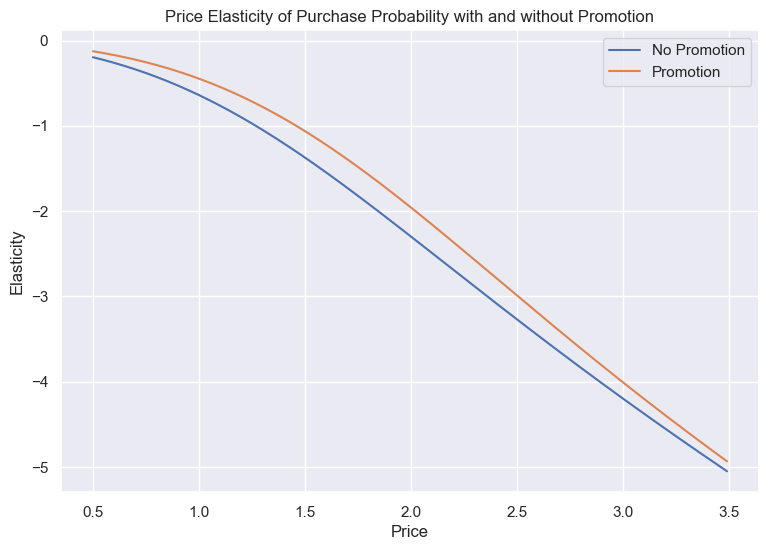

In [29]:
# Plot purchase elasticities with and without promotion side by side for comprarisson.

plt.figure(figsize = (9, 6))
plt.plot(price_range, df_price_elasticities.Elasticity_Promotion_0)
plt.plot(price_range, df_price_elasticities.Elasticity_Promotion_1)
plt.legend(['No Promotion','Promotion'])
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability with and without Promotion')

> Here we observe that the purchase probability elasticity of the customer is less elastic throughout the price range when there is promotion. This is an important insight for marketers, as according to our model people are more likely to buy a product if there is some promotional activity rather than purchase a product with the same price, when it isn't on promotion. 

## ${\textbf{Brand Choice}}$

### Data Preparation

In [30]:
# Here we are interested in determining the brand choice of the customer. 
# Hence, we filter our data, to include only purchase occasion, when a purchase has occured. 

brand_choice = df_pa[df_pa['Incidence'] == 1]

In [31]:
# Here we decide which features to include for prediction.

brand_choice.columns.values

array(['ID', 'Day', 'Incidence', 'Brand', 'Quantity', 'Last_Inc_Brand',
       'Last_Inc_Quantity', 'Price_1', 'Price_2', 'Price_3', 'Price_4',
       'Price_5', 'Promotion_1', 'Promotion_2', 'Promotion_3',
       'Promotion_4', 'Promotion_5', 'Sex', 'Marital status', 'Age',
       'Education', 'Income', 'Occupation', 'Settlement size', 'Segment',
       'Segment_0', 'Segment_1', 'Segment_2', 'Segment_3'], dtype=object)

In [32]:
# Our model will predict the brand.

Y = brand_choice['Brand']

# We predict based on the prices for the five brands.

features = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
X = brand_choice[features]

In [33]:
model_brand_choice = LogisticRegression(solver = 'sag', multi_class = 'multinomial')
model_brand_choice.fit(X, Y)

LogisticRegression(multi_class='multinomial', solver='sag')

In [34]:
# Here are the coeffictients for the model. We have five brands and five features for the price. 

model_brand_choice.coef_

array([[-3.91597163,  0.65845176,  2.41765066,  0.7040715 , -0.20213082],
       [ 1.27460991, -1.87985721, -0.2126548 , -0.20634351,  0.58786767],
       [ 1.62421089,  0.56212375,  0.50098352,  1.03952953,  0.45281823],
       [ 0.57453387,  0.39558551, -1.40061878, -1.24624719,  0.24934721],
       [ 0.44261696,  0.26369619, -1.30536059, -0.29101032, -1.08790228]])

In [35]:
# We create a pandas data frame, which contains to coefficients.

bc_coef = pd.DataFrame(model_brand_choice.coef_)
bc_coef = pd.DataFrame(np.transpose(model_brand_choice.coef_))
coefficients = ['Coef_Brand_1', 'Coef_Brand_2', 'Coef_Brand_3', 'Coef_Brand_4', 'Coef_Brand_5']
bc_coef.columns = [coefficients]
prices = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-3.92,1.27,1.62,0.57,0.44
Price_2,0.66,-1.88,0.56,0.40,0.26
Price_3,2.42,-0.21,0.50,-1.40,-1.31
Price_4,0.70,-0.21,1.04,-1.25,-0.29
Price_5,-0.20,0.59,0.45,0.25,-1.09


## Own Brand Price Elasticity 

* We want to calculate the change in purchase probability when price of own brand and competetor brand is changed. We can notice that brand 4 and brand 5 have close purchase performance and hence we will examine for brand 5 (own_brand ) and brand 4 (comp. brand)

In [36]:
b_val_1 = 5
b_val_2 = 4

In [37]:
def Brand_Price_Elasticity(brand_val_1, brand_val_2, brand_choice_data, model, coef):
    
    global price_range
    
    # We want to calculate price elasticity of own and cross (competetor) brand choice.
    # Here we create a data frame with price columns, which our model will use to predict the brand choice probabilities.
    df_own_brand = pd.DataFrame(index = np.arange(price_range.size))
    df_cross_brand = pd.DataFrame(index = np.arange(price_range.size))
    
    for i in sorted(df_pa['Brand'].unique())[1:]:
        brand_text = str(i)     
        
        if i == brand_val_1:
            df_own_brand['Price_' + brand_text] = price_range
            df_cross_brand['Price_' + brand_text] = brand_choice_data['Price_' + brand_text].mean()
            continue
        if i == brand_val_2:
            df_cross_brand['Price_' + brand_text] = price_range
            df_own_brand['Price_' + brand_text] = brand_choice_data['Price_' + brand_text].mean()
            continue
            
        df_own_brand['Price_' + brand_text] = brand_choice_data['Price_' + brand_text].mean()
        df_cross_brand['Price_' + brand_text] = brand_choice_data['Price_' + brand_text].mean()
        
    # Brand Choice Model prediction for own and cross brand
    predict_own_brand = model.predict_proba(df_own_brand)
    predict_cross_brand = model.predict_proba(df_cross_brand)
    
    # Our model returns the probabilities of choosing each of the 5 brands. 
    # For own brand, we choose particular brand's coeff.
    # For cross brand, we choose competetor brand's coeff.
    pr_own_brand = predict_own_brand[: ][:, brand_val_1 - 1]
    pr_cross_brand = predict_cross_brand[:][:, brand_val_2 - 1]
    
    # We're interested in comparing our brand (brand_val_1) with competetor (brand_val_2), so beta remains our brand coeff.
    beta = coef.iloc[brand_val_1 - 1, brand_val_1 - 1]

    # Calculating price elasticities for own and cross brand choice.
    own_brand_price_elasticity = beta * price_range * (1 - pr_own_brand)
    cross_brand_price_elasticity = -beta * price_range * pr_cross_brand
        
    return own_brand_price_elasticity, cross_brand_price_elasticity

In [38]:
df_price_elasticities['Brand_'+str(b_val_1)], df_price_elasticities['Brand_'+str(b_val_1)+'_Cross_Brand_'+str(b_val_2)] = Brand_Price_Elasticity(b_val_1,b_val_2,brand_choice,model_brand_choice,bc_coef)

df_price_elasticities

,Price_Point,PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_0,Elasticity_Promotion_1,Brand_5,Brand_5_Cross_Brand_4
0,0.50,-0.096363,-0.211189,-0.119112,-0.030946,-0.168026,-0.195639,-0.125704,-0.049056,0.332011
1,0.51,-0.100429,-0.217759,-0.123295,-0.032714,-0.172951,-0.201760,-0.129819,-0.050617,0.337288
2,0.52,-0.104622,-0.224437,-0.127572,-0.034570,-0.177946,-0.207984,-0.134013,-0.052207,0.342507
3,0.53,-0.108945,-0.231224,-0.131943,-0.036516,-0.183012,-0.214310,-0.138287,-0.053827,0.347669
4,0.54,-0.113401,-0.238120,-0.136411,-0.038557,-0.188149,-0.220741,-0.142642,-0.055478,0.352773
...,...,...,...,...,...,...,...,...,...,...
295,3.45,-8.011004,-5.051420,-5.679792,-12.542863,-4.022612,-4.983085,-4.861396,-3.231572,0.162234
296,3.46,-8.036251,-5.068275,-5.699946,-12.579782,-4.037481,-4.999991,-4.879598,-3.247766,0.160334
297,3.47,-8.061463,-5.085112,-5.720064,-12.616684,-4.052333,-5.016877,-4.897770,-3.263928,0.158448
298,3.48,-8.086642,-5.101930,-5.740144,-12.653571,-4.067170,-5.033744,-4.915911,-3.280058,0.156576


Text(0.5, 1.0, 'Own Price Elasticity of Purchase Probability for Brand 5')

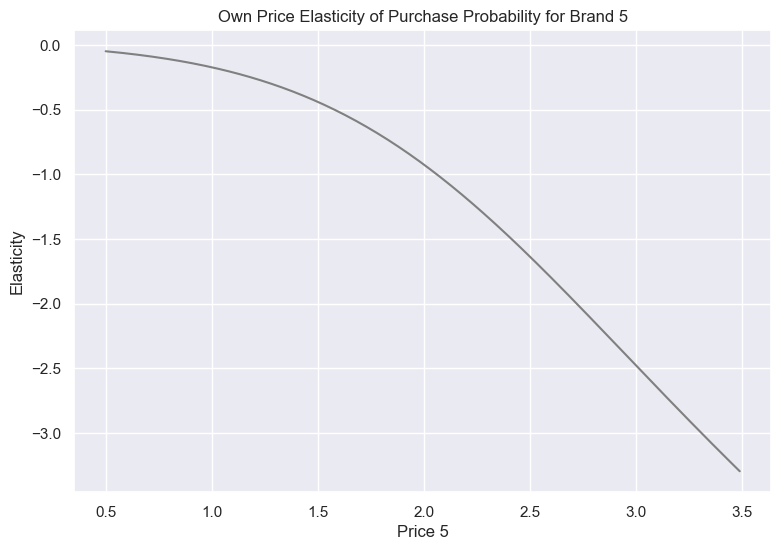

In [39]:
# Plot elasticities of purchase probability for brand 5.

plt.figure(figsize = (9, 6))
plt.plot(price_range,df_price_elasticities['Brand_'+str(b_val_1)], color = 'grey')
plt.xlabel('Price 5')
plt.ylabel('Elasticity')
plt.title('Own Price Elasticity of Purchase Probability for Brand 5')

Text(0.5, 1.0, 'Cross Price Elasticity of Brand 5 wrt Brand 4')

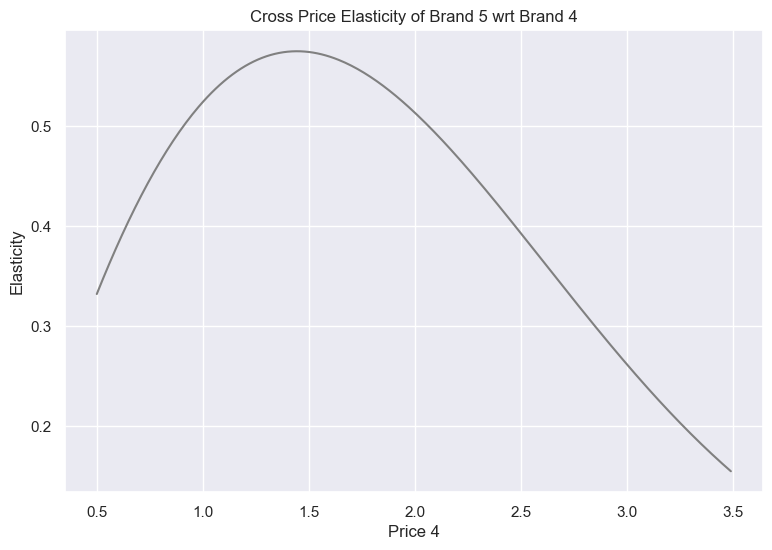

In [40]:
# Here we examine the cross price elasticity of purchase probability for brand 5 with respect to brand 4.

plt.figure(figsize = (9, 6))
plt.plot(price_range, df_price_elasticities['Brand_'+str(b_val_1)+'_Cross_Brand_'+str(b_val_2)], color = 'grey')
plt.xlabel('Price 4')
plt.ylabel('Elasticity')
plt.title('Cross Price Elasticity of Brand 5 wrt Brand 4')

> We observe that the cross price elasticity values of purchase probability for brand 5 with respect to brand 4 are positive. As the price of the competitor brand increases, so does the probability for purchasing our own brand. Even though the elasticity starts to decrease from the 1.45 mark, it is still positive, signalling that the increase in purchase probability for the own brand happens more slowly.

## Own and Cross-Price Elasticity by Segment

#### Data Prep

In [41]:
# We are interested in analysing the purchase probability for choosing particular brand by segments.
# We will look at own and cross price elatisities by various segments of the same brand 5 (own brand) and brand 4 (comp. brand)

seg_b_val_1 = 5
seg_b_val_2 = 4

# We will once again take data where product was purchased
brand_choice_segm = df_pa[df_pa['Incidence'] == 1]

In [42]:
def Brand_Segment_Purchase_Proba(brand_choice_segment, segment_val, coeff):
    
    global features, coefficients, prices, seg_b_val_1, seg_b_val_2
    
    seg_val_text = str(segment_val)
    
    data_brand_choice_segment = brand_choice_segment[brand_choice_segment['Segment'] == segment_val]
    
    # Brand Choice Model estimation.
    Y = data_brand_choice_segment['Brand']
    data_brand_choice_segment = pd.get_dummies(data_brand_choice_segment, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
    X = data_brand_choice_segment[features]
    
    # Fit logistic regression model
    model_brand_choice_segment = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
    model_brand_choice_segment.fit(X, Y)
    
    # Coefficients table
#     bc_coef = pd.DataFrame(np.transpose(model_brand_choice_segment.coef_))
#     bc_coef.columns = [coefficients]
#     bc_coef.index = [prices]
#     bc_coef = bc_coef.round(2)
    bc_coef = coeff
    
    return Brand_Price_Elasticity(seg_b_val_1, seg_b_val_2, data_brand_choice_segment,
                                  model_brand_choice_segment, bc_coef)

In [43]:
# Here we use the original coefficient (for data containing all segments without filter) since our price range is considering
# all the segments and brands together.

for seg_val in sorted(brand_choice_segm.Segment.unique()):
    
    df_price_elasticities['Brand_'+str(seg_b_val_1)+'_S'+str(seg_val)], df_price_elasticities['Brand_'+str(seg_b_val_1)+'_Cross_Brand_'+str(seg_b_val_2)+'_S'+str(seg_val)] = Brand_Segment_Purchase_Proba(brand_choice_segm, seg_val, bc_coef)

df_price_elasticities

,Price_Point,PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_0,Elasticity_Promotion_1,Brand_5,Brand_5_Cross_Brand_4,Brand_5_S0,Brand_5_Cross_Brand_4_S0,Brand_5_S1,Brand_5_Cross_Brand_4_S1,Brand_5_S2,Brand_5_Cross_Brand_4_S2,Brand_5_S3,Brand_5_Cross_Brand_4_S3
0,0.50,-0.096363,-0.211189,-0.119112,-0.030946,-0.168026,-0.195639,-0.125704,-0.049056,0.332011,-0.115831,0.174108,-0.043941,0.194768,-0.001036,0.181596,-0.297315,0.482421
1,0.51,-0.100429,-0.217759,-0.123295,-0.032714,-0.172951,-0.201760,-0.129819,-0.050617,0.337288,-0.118870,0.176163,-0.045027,0.197252,-0.001098,0.183893,-0.303361,0.491726
2,0.52,-0.104622,-0.224437,-0.127572,-0.034570,-0.177946,-0.207984,-0.134013,-0.052207,0.342507,-0.121944,0.178168,-0.046124,0.199685,-0.001163,0.186141,-0.309417,0.501016
3,0.53,-0.108945,-0.231224,-0.131943,-0.036516,-0.183012,-0.214310,-0.138287,-0.053827,0.347669,-0.125053,0.180122,-0.047229,0.202067,-0.001231,0.188341,-0.315484,0.510290
4,0.54,-0.113401,-0.238120,-0.136411,-0.038557,-0.188149,-0.220741,-0.142642,-0.055478,0.352773,-0.128198,0.182025,-0.048344,0.204399,-0.001303,0.190492,-0.321563,0.519548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,3.45,-8.011004,-5.051420,-5.679792,-12.542863,-4.022612,-4.983085,-4.861396,-3.231572,0.162234,-3.592455,0.024054,-1.287425,0.068594,-3.746081,0.023407,-3.337317,0.157474
296,3.46,-8.036251,-5.068275,-5.699946,-12.579782,-4.037481,-4.999991,-4.879598,-3.247766,0.160334,-3.606359,0.023698,-1.297234,0.067971,-3.757523,0.022947,-3.350648,0.152053
297,3.47,-8.061463,-5.085112,-5.720064,-12.616684,-4.052333,-5.016877,-4.897770,-3.263928,0.158448,-3.620219,0.023346,-1.307098,0.067352,-3.768945,0.022495,-3.363975,0.146797
298,3.48,-8.086642,-5.101930,-5.740144,-12.653571,-4.067170,-5.033744,-4.915911,-3.280058,0.156576,-3.634035,0.022999,-1.317017,0.066738,-3.780347,0.022049,-3.377299,0.141702


Text(0.5, 0, 'Price 4')

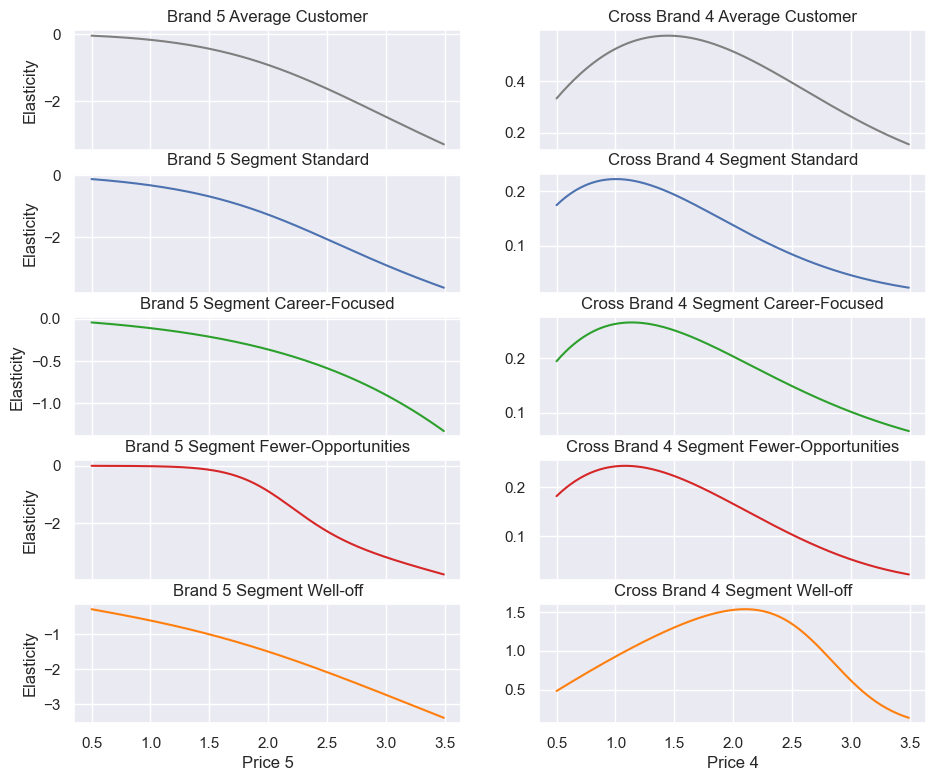

In [44]:
# We plot the own and cross brand price elasticities for the average customer and each of the four segments.

fig1, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 2, figsize = (11, 9), sharex = True)
ax1[0].plot(price_range, df_price_elasticities.Brand_5, 'tab:grey')
ax1[0].set_title('Brand 5 Average Customer')
ax1[0].set_ylabel('Elasticity')
ax1[1].plot(price_range, df_price_elasticities.Brand_5_Cross_Brand_4, 'tab:grey')
ax1[1].set_title('Cross Brand 4 Average Customer')


ax2[0].plot(price_range, df_price_elasticities.Brand_5_S0)
ax2[0].set_title('Brand 5 Segment Standard')
ax2[0].set_ylabel('Elasticity')
ax2[1].plot(price_range, df_price_elasticities.Brand_5_Cross_Brand_4_S0)
ax2[1].set_title('Cross Brand 4 Segment Standard')

ax3[0].plot(price_range, df_price_elasticities.Brand_5_S1, 'tab:green')
ax3[0].set_title('Brand 5 Segment Career-Focused')
ax3[0].set_ylabel('Elasticity')
ax3[1].plot(price_range, df_price_elasticities.Brand_5_Cross_Brand_4_S1, 'tab:green')
ax3[1].set_title('Cross Brand 4 Segment Career-Focused')

ax4[0].plot(price_range, df_price_elasticities.Brand_5_S2, 'tab:red')
ax4[0].set_title('Brand 5 Segment Fewer-Opportunities')
ax4[0].set_ylabel('Elasticity')
ax4[1].plot(price_range, df_price_elasticities.Brand_5_Cross_Brand_4_S2, 'tab:red')
ax4[1].set_title('Cross Brand 4 Segment Fewer-Opportunities')

ax5[0].plot(price_range, df_price_elasticities.Brand_5_S3, 'tab:orange')
ax5[0].set_title('Brand 5 Segment Well-off')
ax5[0].set_xlabel('Price 5')
ax5[0].set_ylabel('Elasticity')
ax5[1].plot(price_range, df_price_elasticities.Brand_5_Cross_Brand_4_S3, 'tab:orange')
ax5[1].set_title('Cross Brand 4 Segment Well-off')
ax5[1].set_xlabel('Price 4')

* The two segments, which seem to be of most interested for the marketing team of brand 5, seem to be the Career-focused
and the Well-off. They are also the segments which purchase this brand most often. 


* The Career-focused segment is the most inelastic and they are the most loyal segment. Based on our model, they do not seem to be that affected by price, therefore brand 5 could increase its price, without fear of significant loss of customers from this segment. 


* The Well-off segment on the other hand, seems to be more elastic. They also purchase the competitor brand 4 most often. In order to target this segment, our analysis signals, that price needs to be decreased. However other factors aside from price might be influencing the purchase behaivour of this segment.

## Price Elasticity of Purchase Quantity

In [45]:
# We want to determine price elasticity of purchase quantity, also known as price elasticity of demand.
# We are interested in purchase occasion where the purchased quantity is different from 0.
# Therefore, once again we filter our data to contain only shopping visits where the client has purchased at least one product.

df_purchase_quantity = df_pa[df_pa['Incidence'] == 1]

# Create brand dummies, for each of the five brands.

df_purchase_quantity = pd.get_dummies(df_purchase_quantity, columns = ['Brand'], prefix = 'Brand', prefix_sep = '_')

df_purchase_quantity.head()

,ID,Day,Incidence,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,...,Segment,Segment_0,Segment_1,Segment_2,Segment_3,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5
6,200000001,28,1,2,0,0,1.50,1.90,1.99,2.09,...,2,0,0,1,0,0,1,0,0,0
11,200000001,58,1,1,0,0,1.39,1.90,1.91,2.12,...,2,0,0,1,0,0,0,0,0,1
19,200000001,110,1,2,0,0,1.47,1.90,1.99,1.97,...,2,0,0,1,0,1,0,0,0,0
24,200000001,142,1,1,0,0,1.21,1.35,1.99,2.16,...,2,0,0,1,0,0,0,0,1,0
29,200000001,183,1,3,0,0,1.46,1.88,1.97,1.89,...,2,0,0,1,0,0,1,0,0,0


In [46]:
df_purchase_quantity.describe()

,ID,Day,Incidence,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,...,Segment,Segment_0,Segment_1,Segment_2,Segment_3,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5
count,1.463800e+04,14638.000000,14638.0,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,...,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000
mean,2.000003e+08,359.607597,1.0,2.774559,1.535251,0.406955,1.384559,1.764717,2.006694,2.159658,...,1.581910,0.175229,0.299290,0.293824,0.231657,0.092226,0.310288,0.057453,0.199959,0.340074
std,1.423786e+02,205.346253,0.0,1.796736,2.060858,0.491283,0.090944,0.181667,0.046200,0.093253,...,1.028171,0.380176,0.457962,0.455528,0.421906,0.289354,0.462627,0.232714,0.399983,0.473750
min,2.000000e+08,1.000000,1.0,1.000000,0.000000,0.000000,1.100000,1.260000,1.870000,1.760000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000001e+08,175.000000,1.0,2.000000,0.000000,0.000000,1.340000,1.570000,1.970000,2.120000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000003e+08,355.000000,1.0,2.000000,0.000000,0.000000,1.390000,1.880000,2.010000,2.180000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000004e+08,532.000000,1.0,3.000000,4.000000,1.000000,1.470000,1.890000,2.060000,2.240000,...,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,2.000005e+08,727.000000,1.0,15.000000,5.000000,1.000000,1.590000,1.900000,2.140000,2.260000,...,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


> The descriptive analysis of the purchase quantitiy data frame, shows that quantity ranges from 1 to 15 and has an average value of 2.8, which means that more often than not our customers buy more than 1 chocolate candy bar.

In [47]:
df_purchase_quantity.shape

(14638, 33)

In [48]:
# Here we make a decission on which features to include in our model. We decide to include a Price and a Promotion feature.

df_purchase_quantity.columns.values

array(['ID', 'Day', 'Incidence', 'Quantity', 'Last_Inc_Brand',
       'Last_Inc_Quantity', 'Price_1', 'Price_2', 'Price_3', 'Price_4',
       'Price_5', 'Promotion_1', 'Promotion_2', 'Promotion_3',
       'Promotion_4', 'Promotion_5', 'Sex', 'Marital status', 'Age',
       'Education', 'Income', 'Occupation', 'Settlement size', 'Segment',
       'Segment_0', 'Segment_1', 'Segment_2', 'Segment_3', 'Brand_1',
       'Brand_2', 'Brand_3', 'Brand_4', 'Brand_5'], dtype=object)

In [49]:
# Let us add Last_inc_quantity_val column that calculates the quantity bought by the customer on their previous visit

for id in df_purchase_quantity.ID.unique():

    df_purchase_quantity.loc[df_purchase_quantity.ID == id, 'Last_Inc_Quantity_Val'] = df_purchase_quantity.loc[df_purchase_quantity.ID == id, 'Quantity'].shift(1, fill_value=0)

In [50]:
df_purchase_quantity.Last_Inc_Quantity_Val = df_purchase_quantity.Last_Inc_Quantity_Val.astype(int)

df_purchase_quantity.loc[:200, ['ID','Incidence','Quantity','Last_Inc_Quantity_Val']]

,ID,Incidence,Quantity,Last_Inc_Quantity_Val
6,200000001,1,2,0
11,200000001,1,1,2
19,200000001,1,2,1
24,200000001,1,1,2
29,200000001,1,3,1
52,200000001,1,3,3
79,200000001,1,2,3
80,200000001,1,3,2
97,200000001,1,1,3
101,200000002,1,1,0


In [51]:
#Find the price of the product that was purchased on that day

df_purchase_quantity['Price_Incidence'] = (df_purchase_quantity['Brand_1'] * df_purchase_quantity['Price_1'] +
                                           df_purchase_quantity['Brand_2'] * df_purchase_quantity['Price_2'] +
                                           df_purchase_quantity['Brand_3'] * df_purchase_quantity['Price_3'] +
                                           df_purchase_quantity['Brand_4'] * df_purchase_quantity['Price_4'] +
                                           df_purchase_quantity['Brand_5'] * df_purchase_quantity['Price_5'] )

In [52]:
#Find the promotions available for the product that was purchased on that day

df_purchase_quantity['Promotion_Incidence'] = (df_purchase_quantity['Brand_1'] * df_purchase_quantity['Promotion_1'] +
                                               df_purchase_quantity['Brand_2'] * df_purchase_quantity['Promotion_2'] +
                                               df_purchase_quantity['Brand_3'] * df_purchase_quantity['Promotion_3'] +
                                               df_purchase_quantity['Brand_4'] * df_purchase_quantity['Promotion_4'] +
                                               df_purchase_quantity['Brand_5'] * df_purchase_quantity['Promotion_5'] )

In [53]:
df_purchase_quantity.describe()

,ID,Day,Incidence,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,...,Segment_2,Segment_3,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5,Last_Inc_Quantity_Val,Price_Incidence,Promotion_Incidence
count,1.463800e+04,14638.000000,14638.0,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,...,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000
mean,2.000003e+08,359.607597,1.0,2.774559,1.535251,0.406955,1.384559,1.764717,2.006694,2.159658,...,0.293824,0.231657,0.092226,0.310288,0.057453,0.199959,0.340074,2.679328,2.099212,0.227422
std,1.423786e+02,205.346253,0.0,1.796736,2.060858,0.491283,0.090944,0.181667,0.046200,0.093253,...,0.455528,0.421906,0.289354,0.462627,0.232714,0.399983,0.473750,1.848368,0.469609,0.419181
min,2.000000e+08,1.000000,1.0,1.000000,0.000000,0.000000,1.100000,1.260000,1.870000,1.760000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.100000,0.000000
25%,2.000001e+08,175.000000,1.0,2.000000,0.000000,0.000000,1.340000,1.570000,1.970000,2.120000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.850000,0.000000
50%,2.000003e+08,355.000000,1.0,2.000000,0.000000,0.000000,1.390000,1.880000,2.010000,2.180000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.090000,0.000000
75%,2.000004e+08,532.000000,1.0,3.000000,4.000000,1.000000,1.470000,1.890000,2.060000,2.240000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,3.000000,2.620000,0.000000
max,2.000005e+08,727.000000,1.0,15.000000,5.000000,1.000000,1.590000,1.900000,2.140000,2.260000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.000000,2.800000,1.000000


In [54]:
# Let us see the distribution of quantity purchased across brands and segments

df_quantity_desc = pd.DataFrame()

df_quantity_desc.index = df_purchase_quantity.describe().index

for i in range(1,6):
    
    df_quantity_desc['Brand_' + str(i)] = df_purchase_quantity.loc[df_purchase_quantity['Brand_' + str(i)] == 1].describe()['Quantity'].round(2)
    
for i in sorted(df_purchase_quantity.Segment.unique()):
    
    df_quantity_desc['Segment'+ str(i)] = df_purchase_quantity.loc[df_purchase_quantity['Segment'] == i].describe()['Quantity'].round(2)

In [55]:
df_quantity_desc

,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5,Segment0,Segment1,Segment2,Segment3
count,1350.00,4542.00,841.00,2927.00,4978.00,2565.00,4381.00,4301.00,3391.00
mean,3.49,2.82,3.56,3.03,2.25,3.13,2.36,2.77,3.05
std,2.04,1.54,2.08,1.67,1.81,1.88,1.80,1.55,1.91
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,2.00,2.00,2.00,2.00,1.00,2.00,1.00,2.00,2.00
50%,3.00,3.00,3.00,3.00,2.00,3.00,2.00,3.00,3.00
75%,4.00,3.00,4.00,4.00,3.00,4.00,3.00,3.00,4.00
max,14.00,13.00,14.00,13.00,15.00,14.00,14.00,13.00,15.00


* We observe that for Quantity purchased, the mean is around 3 and standard deviation is around 2 for various brands and segments. This indicates most of them have purchased around 3 quantities of product in their previous visit with exception of outliers.

## Model Estimation. Linear Regression

In [56]:
X = df_purchase_quantity[['Price_Incidence', 'Promotion_Incidence','Last_Inc_Quantity_Val']]
X

,Price_Incidence,Promotion_Incidence,Last_Inc_Quantity_Val
6,1.90,0,0
11,2.62,1,2
19,1.47,0,1
24,2.16,0,2
29,1.88,0,1
...,...,...,...
58621,1.89,0,6
58648,1.35,1,6
58674,1.85,1,12
58687,1.51,0,7


In [57]:
Y = df_purchase_quantity['Quantity']
Y.head()

6     2
11    1
19    2
24    1
29    3
Name: Quantity, dtype: int64

In [58]:
# Linear Regression Model
model_quantity = LinearRegression()
model_quantity.fit(X, Y)

LinearRegression()

In [59]:
model_quantity.coef_

array([-0.61819085, -0.06835216,  0.39411883])

* The coefficients for price and promotion are both negative. It appears that promotion reflects negatively on the purchase quantity of the average client, which is unexpected.




* But the coefficient for quantity purchased during previous visit is positive which reflects negatively on the purchase quantity

## Price Elasticity with Promotion

In [60]:
# We examine the price elasticity of purchase quantity with active promotional activities for each price point 
# and when the customer bought more than average amount of chocolates on their prev visit.

df_price_elasticity_quantity = pd.DataFrame(index = np.arange(price_range.size))
df_price_elasticity_quantity['Price_Incidence'] = price_range
df_price_elasticity_quantity['Promotion_Incidence'] = 1

# Lets have another column that indicates whether the customer has bought the average amount of chocolates.

df_price_elasticity_quantity['Last_Quantity_Val_Avg'] = df_purchase_quantity.Last_Inc_Quantity_Val.mean()

In [61]:
#Take the coefficient for price.

beta_quantity = model_quantity.coef_[0]
beta_quantity

-0.6181908494320815

In [62]:
predict_quantity = model_quantity.predict(df_price_elasticity_quantity)

In [63]:
# We calculate the price elasticity with our new formula. It is the beta coefficient for price multiplied by price
# and divided by the purchase quantity.

price_elasticity_quantity_promotion_yes = beta_quantity * price_range / predict_quantity

In [64]:
df_price_elasticities['PE_Quantity_Promotion_1'] = price_elasticity_quantity_promotion_yes
df_price_elasticities

,Price_Point,PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_0,Elasticity_Promotion_1,Brand_5,Brand_5_Cross_Brand_4,Brand_5_S0,Brand_5_Cross_Brand_4_S0,Brand_5_S1,Brand_5_Cross_Brand_4_S1,Brand_5_S2,Brand_5_Cross_Brand_4_S2,Brand_5_S3,Brand_5_Cross_Brand_4_S3,PE_Quantity_Promotion_1
0,0.50,-0.096363,-0.211189,-0.119112,-0.030946,-0.168026,-0.195639,-0.125704,-0.049056,0.332011,-0.115831,0.174108,-0.043941,0.194768,-0.001036,0.181596,-0.297315,0.482421,-0.083306
1,0.51,-0.100429,-0.217759,-0.123295,-0.032714,-0.172951,-0.201760,-0.129819,-0.050617,0.337288,-0.118870,0.176163,-0.045027,0.197252,-0.001098,0.183893,-0.303361,0.491726,-0.085114
2,0.52,-0.104622,-0.224437,-0.127572,-0.034570,-0.177946,-0.207984,-0.134013,-0.052207,0.342507,-0.121944,0.178168,-0.046124,0.199685,-0.001163,0.186141,-0.309417,0.501016,-0.086928
3,0.53,-0.108945,-0.231224,-0.131943,-0.036516,-0.183012,-0.214310,-0.138287,-0.053827,0.347669,-0.125053,0.180122,-0.047229,0.202067,-0.001231,0.188341,-0.315484,0.510290,-0.088748
4,0.54,-0.113401,-0.238120,-0.136411,-0.038557,-0.188149,-0.220741,-0.142642,-0.055478,0.352773,-0.128198,0.182025,-0.048344,0.204399,-0.001303,0.190492,-0.321563,0.519548,-0.090574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,3.45,-8.011004,-5.051420,-5.679792,-12.542863,-4.022612,-4.983085,-4.861396,-3.231572,0.162234,-3.592455,0.024054,-1.287425,0.068594,-3.746081,0.023407,-3.337317,0.157474,-1.130413
296,3.46,-8.036251,-5.068275,-5.699946,-12.579782,-4.037481,-4.999991,-4.879598,-3.247766,0.160334,-3.606359,0.023698,-1.297234,0.067971,-3.757523,0.022947,-3.350648,0.152053,-1.137417
297,3.47,-8.061463,-5.085112,-5.720064,-12.616684,-4.052333,-5.016877,-4.897770,-3.263928,0.158448,-3.620219,0.023346,-1.307098,0.067352,-3.768945,0.022495,-3.363975,0.146797,-1.144466
298,3.48,-8.086642,-5.101930,-5.740144,-12.653571,-4.067170,-5.033744,-4.915911,-3.280058,0.156576,-3.634035,0.022999,-1.317017,0.066738,-3.780347,0.022049,-3.377299,0.141702,-1.151562


Text(0.5, 1.0, 'Price Elasticity of Purchase Quantity with Promotion')

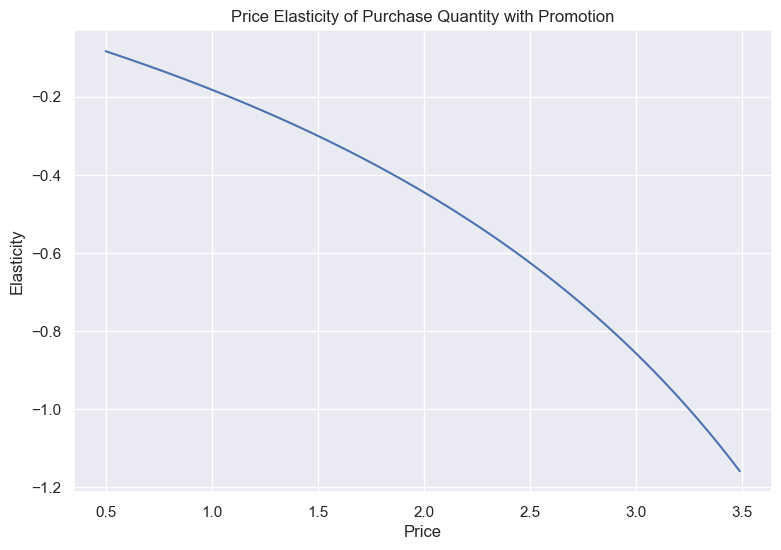

In [65]:
plt.figure(figsize = (9, 6))
plt.plot(price_range, price_elasticity_quantity_promotion_yes)
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Quantity with Promotion')

## Price Elasticity without Promotion

In [66]:
# Overwrite promotion incidence in order to use the same df. 
# Here we assume there are no promotinal activities active for the entire price range.

df_price_elasticity_quantity['Promotion_Incidence'] = 0
# Find the new predicted quantities.
predict_quantity = model_quantity.predict(df_price_elasticity_quantity)
# Calculate the new price elasticities.
price_elasticity_quantity_promotion_no = beta_quantity * price_range / predict_quantity
# Add the results to the master data frame.
df_price_elasticities['PE_Quantity_Promotion_0'] = price_elasticity_quantity_promotion_no
df_price_elasticities

,Price_Point,PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_0,Elasticity_Promotion_1,Brand_5,Brand_5_Cross_Brand_4,Brand_5_S0,Brand_5_Cross_Brand_4_S0,Brand_5_S1,Brand_5_Cross_Brand_4_S1,Brand_5_S2,Brand_5_Cross_Brand_4_S2,Brand_5_S3,Brand_5_Cross_Brand_4_S3,PE_Quantity_Promotion_1,PE_Quantity_Promotion_0
0,0.50,-0.096363,-0.211189,-0.119112,-0.030946,-0.168026,-0.195639,-0.125704,-0.049056,0.332011,-0.115831,0.174108,-0.043941,0.194768,-0.001036,0.181596,-0.297315,0.482421,-0.083306,-0.081799
1,0.51,-0.100429,-0.217759,-0.123295,-0.032714,-0.172951,-0.201760,-0.129819,-0.050617,0.337288,-0.118870,0.176163,-0.045027,0.197252,-0.001098,0.183893,-0.303361,0.491726,-0.085114,-0.083572
2,0.52,-0.104622,-0.224437,-0.127572,-0.034570,-0.177946,-0.207984,-0.134013,-0.052207,0.342507,-0.121944,0.178168,-0.046124,0.199685,-0.001163,0.186141,-0.309417,0.501016,-0.086928,-0.085350
3,0.53,-0.108945,-0.231224,-0.131943,-0.036516,-0.183012,-0.214310,-0.138287,-0.053827,0.347669,-0.125053,0.180122,-0.047229,0.202067,-0.001231,0.188341,-0.315484,0.510290,-0.088748,-0.087135
4,0.54,-0.113401,-0.238120,-0.136411,-0.038557,-0.188149,-0.220741,-0.142642,-0.055478,0.352773,-0.128198,0.182025,-0.048344,0.204399,-0.001303,0.190492,-0.321563,0.519548,-0.090574,-0.088925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,3.45,-8.011004,-5.051420,-5.679792,-12.542863,-4.022612,-4.983085,-4.861396,-3.231572,0.162234,-3.592455,0.024054,-1.287425,0.068594,-3.746081,0.023407,-3.337317,0.157474,-1.130413,-1.090892
296,3.46,-8.036251,-5.068275,-5.699946,-12.579782,-4.037481,-4.999991,-4.879598,-3.247766,0.160334,-3.606359,0.023698,-1.297234,0.067971,-3.757523,0.022947,-3.350648,0.152053,-1.137417,-1.097524
297,3.47,-8.061463,-5.085112,-5.720064,-12.616684,-4.052333,-5.016877,-4.897770,-3.263928,0.158448,-3.620219,0.023346,-1.307098,0.067352,-3.768945,0.022495,-3.363975,0.146797,-1.144466,-1.104199
298,3.48,-8.086642,-5.101930,-5.740144,-12.653571,-4.067170,-5.033744,-4.915911,-3.280058,0.156576,-3.634035,0.022999,-1.317017,0.066738,-3.780347,0.022049,-3.377299,0.141702,-1.151562,-1.110916


Text(0.5, 1.0, 'Price Elasticity of Purchase Quantity with Promotion')

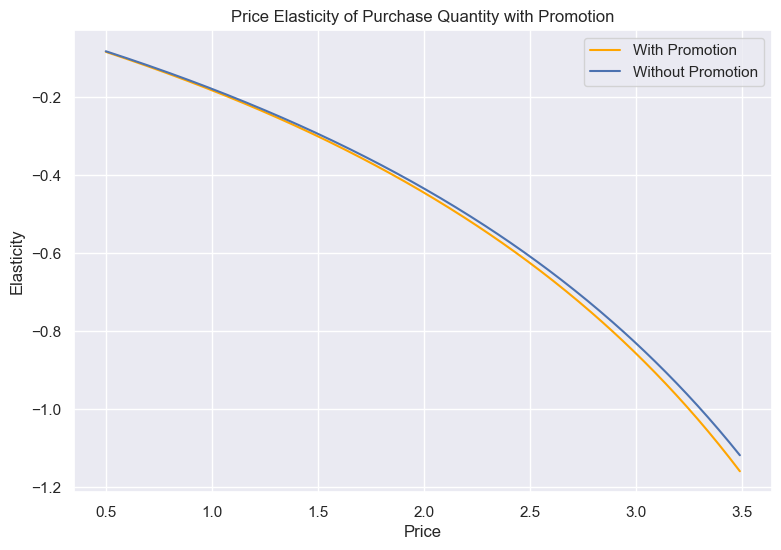

In [67]:
# Plot the two elasticities side by side. 
# We observe that the two elasticities are very close together for almost the entire price range.
# It appears that promotion does not appear to be a significant factor in the customers' decission 
# what quantity of chocolate candy bars to purchase.
plt.figure(figsize = (9, 6))
plt.plot(price_range, price_elasticity_quantity_promotion_yes, color = 'orange')
plt.plot(price_range, price_elasticity_quantity_promotion_no)
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.legend(['With Promotion','Without Promotion'])
plt.title('Price Elasticity of Purchase Quantity with Promotion')

* For the selling price range of all our brands combined [1.10 to 2.80], we see that the customers are inelastic for the most part. So price, promotion doesn't seem to be affecting them that much. Further, even though there was positive coefficient for prev quantity purchased, it doesn't seem to be affecting to a significant extent.


* Since there is a great deal of overlap b/w no promotion and promotion, promotion doesn't seem to be a good predictor for our model. (although this is considering all segments and brands at once).